# How It Works

### [Get your Own API KEY Today!](https://www.private-ai.com/api-key/)



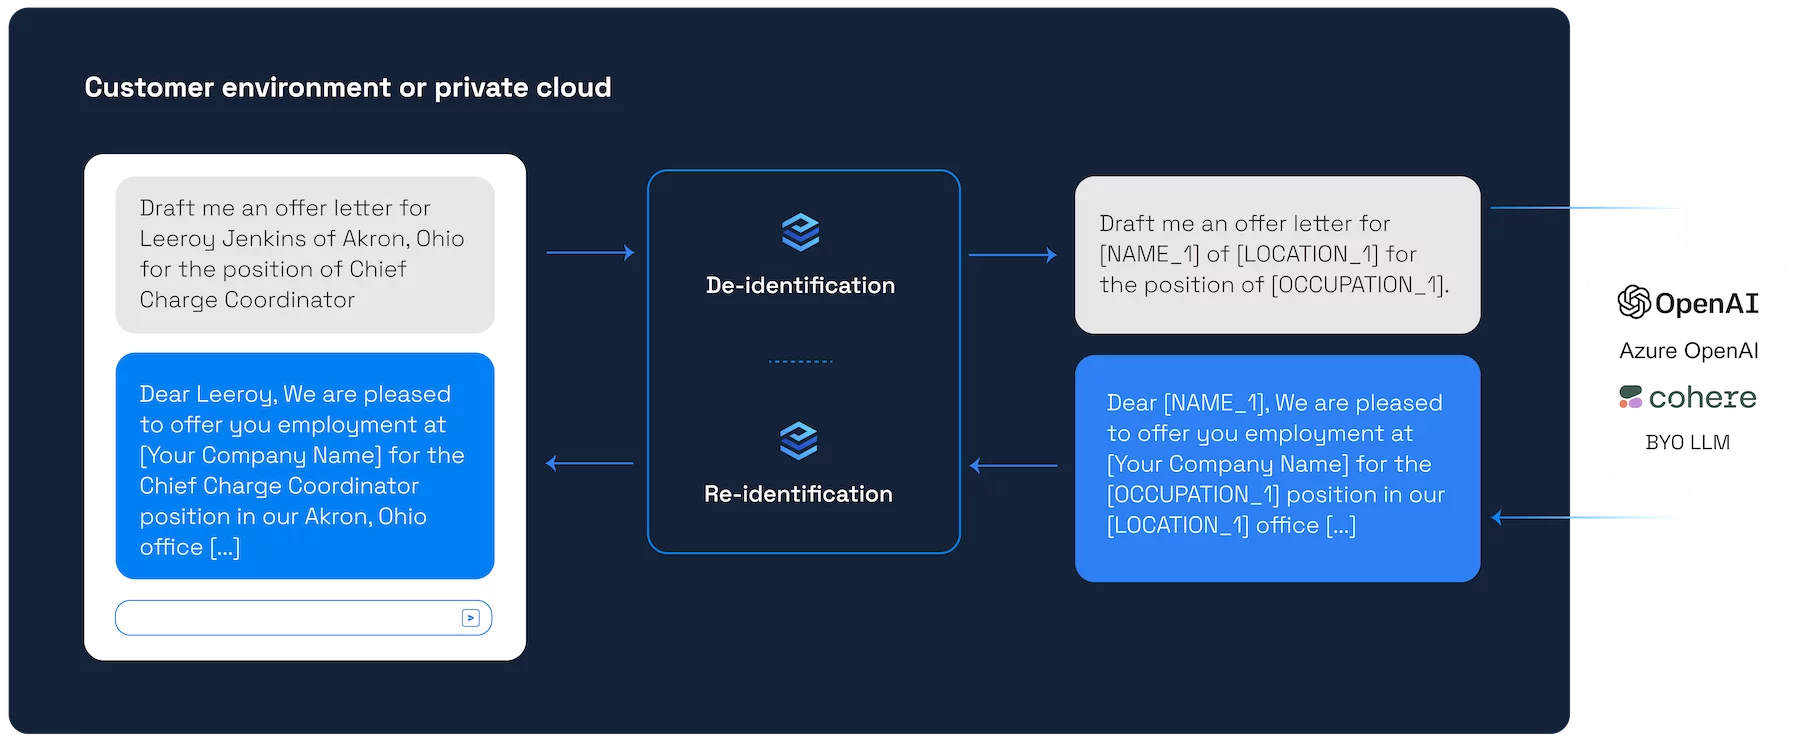

# A Complex Example

In this example we will construct a prompt for a legal document know as an LOI. This is an M&A transaction document that contains large amounts of sensitive data. Obvisouly you don't want this type of content getting out into the wild... so we'll make sure that doesn't happen!

![alt text](../../images/LOI_image.png "LOI Example")

## Redacting the File

The first step we will take is taking this super sensitive document, and making it look like this

![alt text](../../images/redacted_LOI.png "LOI Redacted")

As you can see now, the sensitive data elements have been removed, redering the entire document to be non-material to a 3rd party without direct knowledge of the transation. We can still see that this document is related to an M&A transaction, but we can't see the details. That is an important point. Without knowing the document is related to M&A, we are unable to use LLMs to gain any insights that will be relevant. In short, we want LLMs to know as much as possible, without breaching the PII, organizational data, dollar amounts, and anything else that could uniquely identify the transaction

In [2]:
from privateai_client import PAIClient
from privateai_client import request_objects
import openai
import os
import json
import requests
import fitz

PRIVATEAI_API_KEY = "API KEY HERE" #this is required only if you are using our public API
PRIVATEAI_URL = "YOUR PAI URL HERE" # your hosted URL, or our public demo URL
openai.api_key = "YOU OPENAI API KEY HERE"

In [4]:
client = PAIClient("https", PRIVATEAI_URL )

In [5]:
#Create some wrapper functions

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff


@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.Completion.create(**kwargs)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def chat_completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

def regex_redact(raw_text):
    pattern = "(?:\\d+([\\.,]\\d+)?\\s?%)|(?:%\\s?\\d+([\\.,]\\d+)?)"
    filter_obj = request_objects.filter_selector_obj(type="BLOCK", pattern=pattern, entity_type="PERCENTAGE")
    request_obj = request_objects.process_text_obj(text=[raw_text])
    request_obj.entity_detection.filter= [filter_obj]
    response_obj = client.process_text(request_obj)
    return response_obj
    


## Here we read the file into text

We have the ability to send the file directly to our redaction service, but for now we will just grab the text.

Note: We have the ability to redact an entire file via our process file route( [URI](https://docs.private-ai.com/reference/latest/operation/process_files_uri_v3_process_files_uri_post/) and [Base64](https://docs.private-ai.com/reference/latest/operation/process_files_base64_v3_process_files_base64_post/) ), but for right now we will use the fritz library.

In [8]:
filepath =  "sample_pdfs/Letter-of-Intent-pdf.pdf"
doc = fitz.open(filepath)
raw_text = ""
for page in doc:
    text = page.get_text()
    raw_text = raw_text+"\n"+text
    print(text)

CONFIDENTIAL 
Date 
BY ELECTRONIC MAIL 
Sarah Jackson 
123 Main Street, Toronto ON 
Dear Sam Matthews, 
We are writing to provide a letter of intent from Best Capital Partners. (“BCP”) in respect of a 
transaction (a “Transaction”) with Matthews Industries Inc. (the “Company”).  We appreciate the 
time and energy you and your team have afforded us in discussing this opportunity and the 
information that has been provided thus far.   
As we continue to spend time evaluating Matthews Industries Inc., we believe that Best Capital 
Partners will bring unique value and capabilities to the Company, accelerating the development 
and growth of Matthews Industries Inc..  We believe we could drive Matthews Industries Inc.’s 
growth strategy, by doing roll-up M&A, investing in growth activities and creating leverage 
through streamlined financing opportunities. 
Transaction Overview and Structure 
Based on our preliminary review of the information provided and subject to the conditions set 
forth

## Prepare our Secure Prompt Function

Here we are building a nice and tidy function that; 1) redacts the raw text that is sent in, 2) sends the redacted text + prompt to openAI, and 3) re-identifies the redacted information (for a better user experience that reading redacted files)

In [9]:
# Deidentify the text
def secure_completion(prompt, raw_text, temp):
    ##########################################
    ######## REDACT DATA #####################
    ##########################################
    completions = {}
    response_obj =  regex_redact(raw_text)

    ##########################################
    ######## BUILD LOCAL ENTITIES MAP ########
    ##########################################
    deidentified_text = response_obj.processed_text
    completions['redactect_raw_text'] = deidentified_text
    entity_list = [request_objects.entity(row['processed_text'], row['text']) for row in response_obj.entities[0]]
    
    ##########################################
    ######## SEND REDACTED PROMPT TO LLM #####
    ##########################################
    MODEL = "gpt-4" # "gpt-3.5-turbo"
    PRE_PROMPT = "Leave any text markers like [value] alone. "
    completion = chat_completion_with_backoff(
            model=MODEL,
            temperature=temp,
            messages=[
            {"role": "user", 
             "content": f'{prompt}: {deidentified_text}'}
            ]
        )
    completions["redacted"] = completion.choices[0].message['content']
    
    ##########################################
    ######## RE-IDENTIFY COMPLETION ##########
    ##########################################
    request_obj = request_objects.reidentify_text_obj(
        processed_text=[completion.choices[0].message['content']], entities=entity_list
    )
    response_obj = client.reidentify_text(request_obj)
    completions["reidentified"] = response_obj.body[0]
    return completions

## An example Use

Here I want to ask openAI to summarize the transaction for me. We are going to build you a dictionary object `secure_transaction_summary` so you can see exactly what happened to the text, the completion, and the re-identification

In [10]:
secure_transaction_summary = secure_completion(
    "Write a short summary of this document including details of the organizations involved",
    raw_text,
    0.8
)

In [11]:
from IPython.display import display, Markdown, Latex
print("****************************************************************************")
print("REDACTED INPUT TEXT")
print("****************************************************************************")
print(secure_transaction_summary['redactect_raw_text'])
print("****************************************************************************")
print("REDACTED CHAT COMPLETION FROM OPENAI")
print("****************************************************************************")
print(secure_transaction_summary["redacted"])
print("****************************************************************************")
print("RE-IDENTIFIED COMPLETION")
print("****************************************************************************")
print(secure_transaction_summary["reidentified"])

****************************************************************************
REDACTED INPUT TEXT
****************************************************************************
['\nCONFIDENTIAL \nDate \nBY ELECTRONIC MAIL \n[NAME_1] \n[LOCATION_ADDRESS_1] \nDear [NAME_2], \nWe are writing to provide a letter of intent from [ORGANIZATION_1]. (“[ORGANIZATION_2]”) in respect of a \ntransaction (a “Transaction”) with [ORGANIZATION_3]. (the “Company”).  We appreciate the \ntime and energy you and your team have afforded us in discussing this opportunity and the \ninformation that has been provided thus far.   \nAs we continue to spend time evaluating [ORGANIZATION_3]., we believe that [ORGANIZATION_4] will bring unique value and capabilities to the Company, accelerating the development \nand growth of [ORGANIZATION_3]..  We believe we could drive [ORGANIZATION_3].’s \ngrowth strategy, by doing roll-up M&A, investing in growth activities and creating leverage \nthrough streamlined financing opp

## That was pretty amazing!

As you can see, the completion that openAI sends us is completely redacted, and without knowing the context of the raw text in the file you would have no way of know who is involved in the transaction. Once we re-identify the completion, the result is now completely clear. Amazing how well it works right?!?

## More complex examples

Now let's do a few hard things like entity extraction, function calls, etc. so that we can impress you even more :) 

In [12]:
redacted_prompt_completion_text = secure_completion(
    "",
    "Please itemize this document: "+raw_text,
    0.8
)

In [13]:
print(redacted_prompt_completion_text['redacted'])

1. A letter of intent is being sent from [ORGANIZATION_1] to [NAME_2] concerning a proposed transaction with [ORGANIZATION_3].
2. The intent of [ORGANIZATION_1] is to bring value and capabilities to [ORGANIZATION_3] that will accelerate its development and growth.
3. [ORGANIZATION_1] proposes purchasing [PERCENTAGE_1]% of the equity of [ORGANIZATION_3], including all assets and liabilities.
4. The proposed purchase price is [MONEY_1] consisting of [MONEY_2] in cash, shares of [ORGANIZATION_1] valued at [MONEY_3] and [MONEY_4] worth of performance shares.
5. The purchase price is subject to adjustment for changes in net working capital.
6. An illustrative timeline is provided detailing the steps leading up to the drafting of the definitive agreement.
7. The due diligence process includes commercial, accounting and financial due diligence, as well as customary legal, tax and regulatory work.
8. [ORGANIZATION_1] requires sixty days of exclusivity to finalize their due diligence and negoti

In [14]:
data_extract = secure_completion(
    """
    Please create a json array of all of the percentages mentioned in this document. 
    The json item should have the 3 keys of: category, amount. 
    """,
    raw_text,0.8)

In [15]:
json.loads(data_extract['redacted'])

[{'category': 'equity', 'amount': '[PERCENTAGE_1]'},
 {'category': 'shares', 'amount': '[PERCENTAGE_2]'},
 {'category': 'performance_shares', 'amount': '[PERCENTAGE_2]'},
 {'category': 'growth_year1', 'amount': '[PERCENTAGE_3]'},
 {'category': 'growth_year2', 'amount': '[PERCENTAGE_4]'}]

In [ ]:
funny_response = secure_completion(
    """
    Please create a json array of all of the money mentioned in this document. 
    The json item should have the 3 keys of: category, amount, and sarcastic_comment. 
    The sarcastic comment should be in the style of an infomercial spokesperson
    """,
    raw_text,0.8)

In [ ]:
json.loads(funny_response['redacted'])

## Real Producivity Gains Coming up!

Let's say that you are an analyst at KKR who is really gunning for that promotion. How can you make yourself useful?.. By absolutely cranking out solid work product. Usually this means your in the office from 8AM - 9PM every day. But those days are over! Simply whip up some handy GenAI powered tools, with safety and security in mind of course, and run the code below!

In [ ]:
from pathlib import Path
files_list = []
for child in Path('./sample_data/').iterdir():
    if child.is_file():
        files_list.append(child.read_text())


In [ ]:
for file in files_list:
    secure_completion(
    "Summarize this document, be short and concise and include money amounts and people",
    file,0.8)